#CUDA and Libs

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [143]:
print(torch.__version__)  # версия PyTorch
print(torch.cuda.is_available())  # Доступность GPU

2.1.0+cu121
True


# Создаем dataloader

In [144]:
batch_size = 64
lr = 0.0002
n_epochs = 100

In [145]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [146]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [147]:
len(train_loader)

938

In [148]:
image, label = next(iter(train_loader))
image.size()

torch.Size([64, 1, 28, 28])

# WGAN с Условием

##Модель

In [149]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=28*28, num_classes=10):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(num_classes, latent_dim)

        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 128),  # latent_dim * 2, так как объединяем шум и условие
            nn.LeakyReLU(0.2),
            nn.Linear(128, img_shape),
            nn.Tanh()
        )

    def forward(self, z, labels):
        embedded_labels = self.embed(labels).squeeze()
        combined = torch.cat([z, embedded_labels], dim=1)
        return self.model(combined)

class Discriminator(nn.Module):
    def __init__(self, img_shape=28*28, num_classes=10):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, img_shape)

        self.model = nn.Sequential(
            nn.Linear(img_shape * 2, 128),  # img_shape * 2, так как объединяем изображение и условие
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, img, labels):
        embedded_labels = self.embed(labels).squeeze()
        combined = torch.cat([img.view(img.size(0), -1), embedded_labels], dim=1)
        return self.model(combined)

## Обучение с клипингом весов

In [156]:
num_epochs = 50
n_classes = 10
G_losses_clip = []
D_losses_clip = []

clip_value = 0.01

In [157]:
# Функция для клиппинга весов дискриминатора
def clip_weights(discriminator, clip_value):
    for p in discriminator.parameters():
        p.data.clamp_(-clip_value, clip_value)

In [158]:
generator_clip = Generator().to(device)
discriminator_clip = Discriminator().to(device)

In [159]:
optimizer_G_clip = optim.RMSprop(generator_clip.parameters(), lr=0.00005)
optimizer_D_clip = optim.RMSprop(discriminator_clip.parameters(), lr=0.00005)

In [160]:
generated_images_per_epoch = []

# Обучение
for epoch in range(num_epochs):
    generated_epoch = []

    for i, (imgs, labels) in enumerate(train_loader):
        #######
        # discriminator_clip stage
        #######
        optimizer_D_clip.zero_grad()
        # Клиппинг весов дискриминатора
        for p in discriminator_clip.parameters():
            p.data.clamp_(-clip_value, clip_value)

        real_labels = labels.to(device)
        real_imgs = imgs.view(imgs.size(0), -1).to(device)

        z = torch.randn(imgs.size(0), 100).to(device)
        fake_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
        fake_imgs = generator_clip(z, fake_labels)

        loss_D = -(torch.mean(discriminator_clip(real_imgs, real_labels)) - torch.mean(discriminator_clip(fake_imgs, fake_labels)))

        loss_D.backward()
        optimizer_D_clip.step()

        #######
        # generator_clip stage
        #######
        if i % 5 == 0:  # Обновление генератора чаще для улучшения стабильности
            optimizer_G_clip.zero_grad()

            z = torch.randn(imgs.size(0), 100).to(device)
            fake_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
            fake_imgs = generator_clip(z, fake_labels)

            loss_G = -torch.mean(discriminator_clip(fake_imgs, fake_labels))

            loss_G.backward()
            optimizer_G_clip.step()

            G_losses_clip.append(loss_G.item())
            D_losses_clip.append(loss_D.item())



    # Сохранение сгенерированных изображений для текущей эпохи
    with torch.no_grad():
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
              f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


        z = torch.randn(imgs.size(0), 100).to(device)
        generated = generator_clip(z, fake_labels).view(-1, 28, 28).cpu().numpy()
        generated_epoch.extend(fake_imgs)

        plt.figure(figsize=(10, 1))
        for i, img in enumerate(generated[:16]):
            plt.subplot(1, 16, i+1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()

        # Добавление сгенерированных изображений текущей эпохи в список всех изображений
        generated_images_per_epoch.append(generated_epoch)

Output hidden; open in https://colab.research.google.com to view.

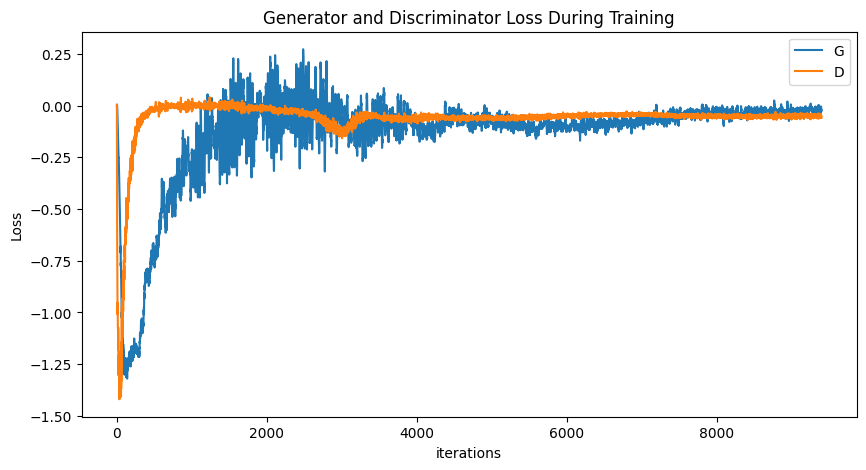

In [161]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_clip,label="G")
plt.plot(D_losses_clip,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Обучение со штрафом на градиенты

In [150]:
num_epochs = 50
n_classes = 10
G_losses_grad = []
D_losses_grad = []

lambda_gp = 10

In [151]:
# Градиентное наказание (Gradient Penalty)
def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    prob_interpolated = discriminator(interpolated, labels)
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                              grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [152]:
generator_grad = Generator().to(device)
discriminator_grad = Discriminator().to(device)

In [153]:
optimizer_G_grad = optim.RMSprop(generator_grad.parameters(), lr=0.00005)
optimizer_D_grad = optim.RMSprop(discriminator_grad.parameters(), lr=0.00005)

In [154]:
generated_images_per_epoch = []

# Обучение
for epoch in range(num_epochs):
    generated_epoch = []

    for i, (imgs, labels) in enumerate(train_loader):
        #######
        # Discriminator stage
        #######
        optimizer_D_grad.zero_grad()

        real_labels = labels.to(device)
        real_imgs = imgs.view(imgs.size(0), -1).to(device)

        z = torch.randn(imgs.size(0), 100).to(device)
        fake_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
        fake_imgs = generator_grad(z, fake_labels)

        loss_D = -(torch.mean(discriminator_grad(real_imgs, real_labels)) - torch.mean(discriminator_grad(fake_imgs, fake_labels)))

        gradient_penalty = compute_gradient_penalty(discriminator_grad, real_imgs.data, fake_imgs.data, real_labels)

        loss_D += lambda_gp * gradient_penalty

        loss_D.backward()
        optimizer_D_grad.step()

        #######
        # Generator stage
        #######
        if i % 5 == 0:  # Обновление генератора чаще для улучшения стабильности
            optimizer_G_grad.zero_grad()

            z = torch.randn(imgs.size(0), 100).to(device)
            fake_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
            fake_imgs = generator_grad(z, fake_labels)

            loss_G = -torch.mean(discriminator_grad(fake_imgs, fake_labels))

            loss_G.backward()
            optimizer_G_grad.step()

            G_losses_grad.append(loss_G.item())
            D_losses_grad.append(loss_D.item())



    # Сохранение сгенерированных изображений для текущей эпохи
    with torch.no_grad():
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
              f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


        z = torch.randn(imgs.size(0), 100).to(device)
        generated = generator_grad(z, fake_labels).view(-1, 28, 28).cpu().numpy()
        generated_epoch.extend(fake_imgs)

        plt.figure(figsize=(10, 1))
        for i, img in enumerate(generated[:16]):
            plt.subplot(1, 16, i+1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()

        # Добавление сгенерированных изображений текущей эпохи в список всех изображений
        generated_images_per_epoch.append(generated_epoch)

Output hidden; open in https://colab.research.google.com to view.

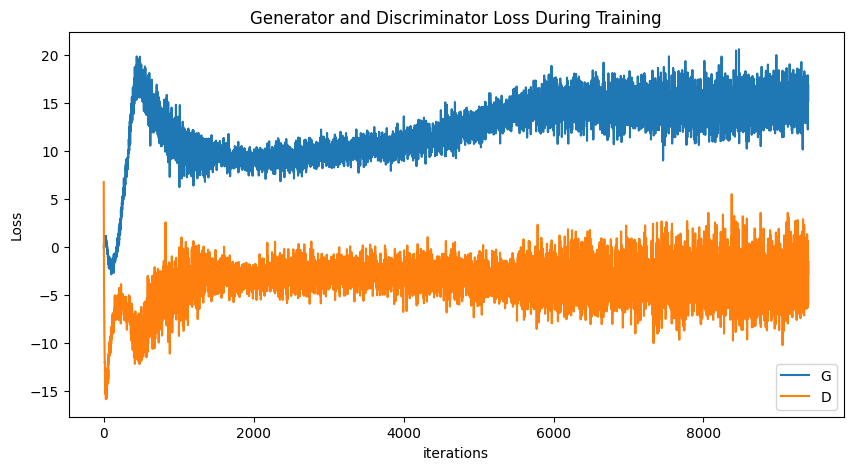

In [155]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_grad,label="G")
plt.plot(D_losses_grad,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Итоговый граф по Клип и Град

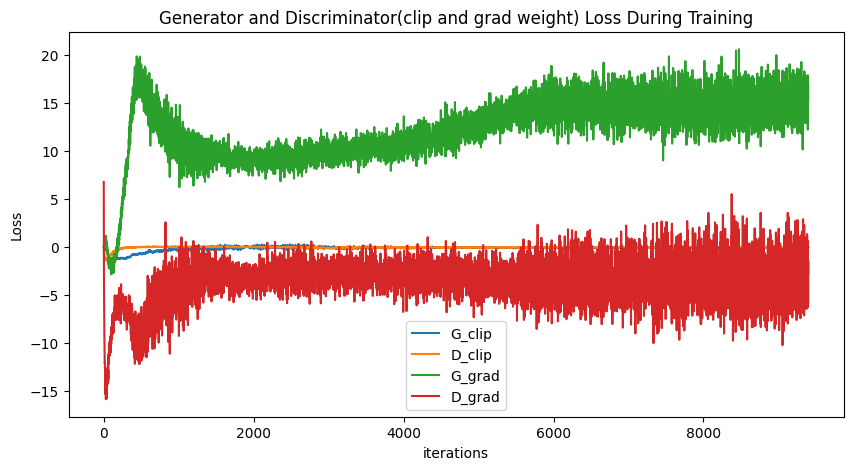

In [162]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator(clip and grad weight) Loss During Training")
plt.plot(G_losses_clip,label="G_clip")
plt.plot(D_losses_clip,label="D_clip")
plt.plot(G_losses_grad,label="G_grad")
plt.plot(D_losses_grad,label="D_grad")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()